In [1]:
import pandas as pd
import librosa
from IPython.display import Audio
import matplotlib
import matplotlib.pyplot as plt
import librosa.display
import os
from scipy.io.wavfile import write
import numpy as np
from numpy.fft import fft, ifft, fftfreq
from scipy import fftpack
from matplotlib.font_manager import FontProperties
from scipy import signal
import ntpath
from numpy.lib import stride_tricks

In [2]:
#1. Считываем файл

name = 'Hotel_California.wav'
dt , rt = librosa.load(name)
#write('H_C.wav', rate = rt, data = dt)
Audio(name)

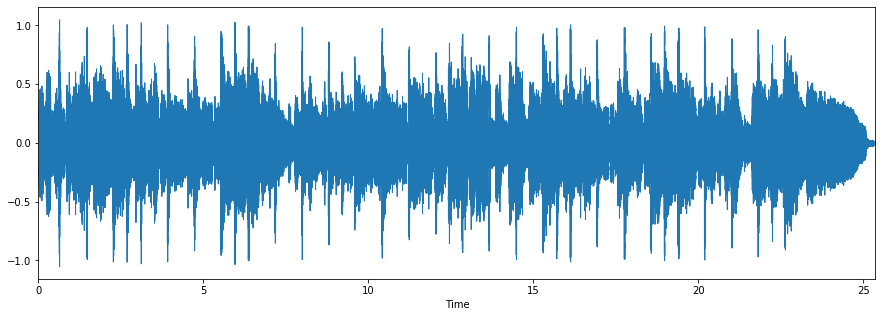

In [3]:
plt.figure(figsize = (15, 5))
librosa.display.waveplot(dt, sr=rt)

In [4]:
#2. Добавляем писк (правильно подобранная синусоида), записываем в файл обратно

time = np.linspace(0., dt.shape[0] / rt, dt.shape[0])
new_dt = np.sin(2 * np.pi * 6000 * time) + dt  
write('H_C.wav', rate = rt, data = new_dt) # сохранила в копию файла для удобства 
Audio('H_C.wav')

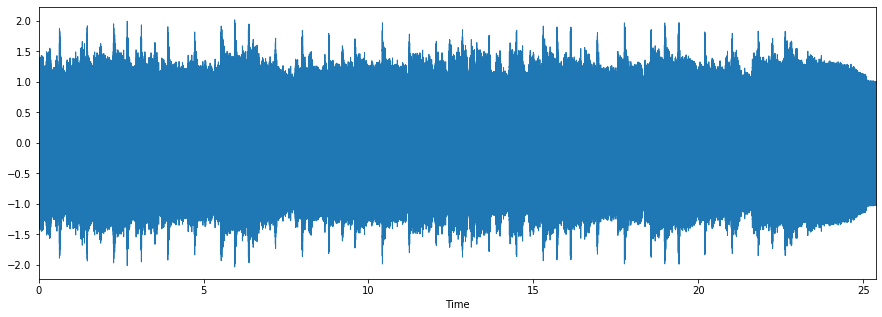

In [5]:
plt.figure(figsize = (15, 5))
librosa.display.waveplot(new_dt, sr=rt)

In [6]:
#3. Спектрограмма (не через библиотечные)

def spectrograma(rt, dt):

    step = int(2**10 / 2)  
    samples = np.append(np.zeros(int(2**10 / 2)), dt) 
    cols = np.ceil((len(samples) - 2**10) / step) + 1
    samples = np.append(samples, np.zeros(2**10)) 
    frames = stride_tricks.as_strided(samples, shape=(int(cols), 2**10), strides=(samples.strides[0] * step, samples.strides[0])).copy()
    frames *= np.hanning(2**10) 
    spec = np.fft.rfft(frames)
    
    time_bins, frequency_bins = np.shape(spec)
    scale = np.linspace(0, 1, frequency_bins)
    scale *= (frequency_bins-1)/max(scale)
    scale = np.unique(np.round(scale))
    new_spectrogram = np.complex128(np.zeros([time_bins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            new_spectrogram[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            new_spectrogram[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)
    all_frequencies = np.abs(np.fft.fftfreq(frequency_bins*2, 1./rt)[:frequency_bins+1])
    freq = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freq += [np.mean(all_frequencies[int(scale[i]):])]
        else:
            freq += [np.mean(all_frequencies[int(scale[i]):int(scale[i+1])])]
    
    data = 20. * np.log10(np.abs(new_spectrogram) / 10e+6) 
    time_bins, freq_bins = np.shape(data)

    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(data), origin='lower', aspect='auto', cmap='nipy_spectral', interpolation='none')
    plt.xlabel('Time[sec]')
    plt.ylabel('Frequency')
    plt.xlim([0, time_bins-1])
    plt.ylim([0, freq_bins])
    plt.colorbar().ax.set_xlabel
    x = np.float32(np.linspace(0, time_bins-1, 10))
    plt.xticks(x, ['%.02f' % i for i in ((x*len(dt)/time_bins)+(0.5 * 2**10))/rt])
    y = np.int16(np.round(np.linspace(0, freq_bins-1, 20)))
    plt.yticks(y, ['%.02f' % freq[i] for i in y])
    plt.show()

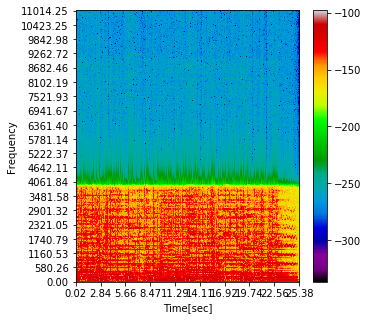

In [7]:
# Для файла без писка

spectrograma(rt, dt)

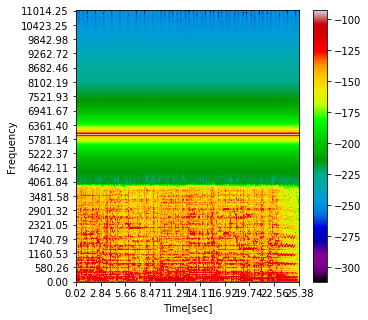

In [8]:
#4. Для файла с писком, видно влияние синусоиды

spectrograma(rt, new_dt) 

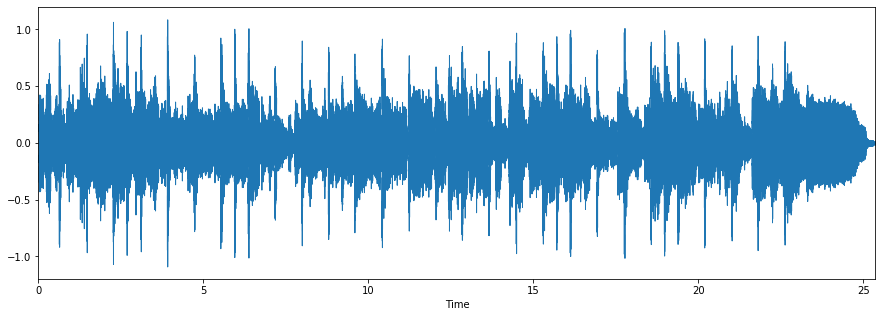

In [9]:
#5. Фильтр Чебышева (во временной шкале, чтобы убрать писк)

sos = signal.cheby1(10, 0.1, 1800, 'low', fs=rt, output='sos')
filtered = signal.sosfilt(sos, new_dt)

plt.figure(figsize = (15, 5))
librosa.display.waveplot(filtered, sr=rt)

In [10]:
Audio(filtered,rate = rt)

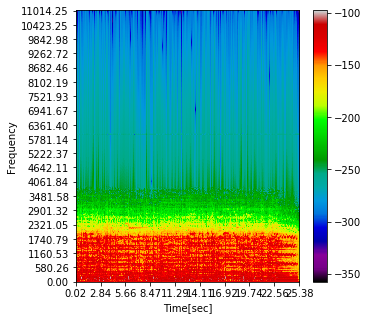

In [11]:
#6. Как повлияло на спектрограмму

spectrograma(rt, filtered)

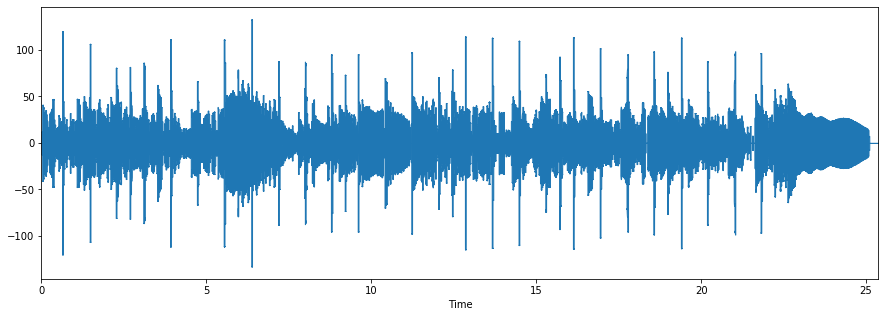

In [26]:
#7-8. Гармоники и график

step = int(2**10 / 2)  
samples = np.append(np.zeros(int(2**10 / 2)), dt) 
cols = np.ceil((len(samples) - 2**10) / step) + 1
samples = np.append(samples, np.zeros(2**10)) 
frames = stride_tricks.as_strided(samples, shape=(int(cols), 2**10), strides=(samples.strides[0] * step, samples.strides[0])).copy()
frames *= np.hanning(2**10) 
spec = np.fft.rfft(frames)

time_bins, frequency_bins = np.shape(spec)
scale = np.linspace(0, 1, frequency_bins)
scale *= (frequency_bins-1)/max(scale)
scale = np.unique(np.round(scale))
new_spectrogram = np.complex128(np.zeros([time_bins, len(scale)]))
for i in range(0, len(scale)):        
    if i == len(scale)-1:
        new_spectrogram[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
    else:        
        new_spectrogram[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)
all_frequencies = np.abs(np.fft.fftfreq(frequency_bins*2, 1./rt)[:frequency_bins+1])
freq = []
for i in range(0, len(scale)):
    if i == len(scale)-1:
        freq += [np.mean(all_frequencies[int(scale[i]):])]
    else:
        freq += [np.mean(all_frequencies[int(scale[i]):int(scale[i+1])])] 
    
data = np.abs(new_spectrogram)

# будем выделять частоты с максимальной амплитудой на каждом куске времени
amp = np.zeros(time_bins)
f = np.zeros(time_bins)
for i in range(time_bins):
    amp[i] = data[i].max()
    f[i] = freq[data[i].argmax()]

# и суммировать все получающиеся синусоиды
harmonic = np.array([])
delta_t = np.ceil(dt.shape[0] / time_bins)
for i in range(time_bins):
    time = np.linspace(i*delta_t, (i+1)*delta_t, delta_t)
    harmonic = np.append(harmonic, amp[i]* np.sin(2*np.pi*f[i]*time))
    
plt.figure(figsize=(15, 5))
librosa.display.waveplot(harmonic, sr=rt)

In [43]:
#9. Ускорение

rate = 1.75
speed_dt = np.zeros(int(dt.shape[0]/rate) + 2**10)
phase  = np.zeros(2**10)
for i in np.arange(0, dt.shape[0]-(2**10 + 2**8), 2**8 * rate).astype(int):
    frame_1 = dt[i: i + 2**10] * np.hanning(2**10)
    frame_2 = dt[i + 2**8: i + 2**10 + 2**8] * np.hanning(2**10)
    spec_frame_1 =  np.fft.fft(frame_1)
    spec_frame_2 =  np.fft.fft(frame_2)
    phase = (phase + np.angle(spec_frame_2/spec_frame_1)) % 2*np.pi
    rephased = np.fft.ifft(np.abs(spec_frame_2)*np.exp(1j*phase))
    speed_dt[int(i/rate) : int(i/rate) + 2**10] =  speed_dt[int(i/rate) : int(i/rate) + 2**10] + (np.hanning(2**10) * rephased)

Audio(speed_dt, rate = rt)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


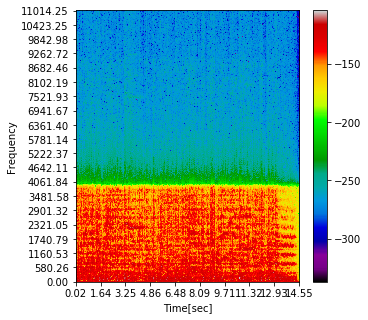

In [44]:
spectrograma(rt, speed_dt)